
-----------

### **Backtesting Optimization**

❎ *' Version 1.2 '*

- In this Version We'll examine the our historical Back test Returns Over Time Across All the Assets that are Available Now.

  - ⚡The Current Workflow:

    - We Use **All** the **Assets** with the **Same Time Lines**.
    
    - For each Asset , We First Build a Portfolio that we put all the initial Investment **(1,000 $)** at the First of the Period to the End in Continiuous Compounding Way.
    
    - Based on the Historical Performances , We Construct a **Portfolio Matrix** With **All** the Asset Performance.
    
    - With having all the Historical Performance of the Assets Based On the Strategy , We Start To Build a Diversified Portfolio Based on the **Optimum Combinantion** of the ***Weights*** and ***Assets*** Where it Will **Maximize the Portfolio Cumulative Return**.
    
    - The Methods Are Used Within the Current Analysis are:

      - 🔍 Naive Asset Allocation
        - Equal Weight
        - Inverse Volatility

      - 🔍 Mean Variance Optimization

----------

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns

import math

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv(
    'Total Backtest 12H.csv',
    parse_dates=['EntryTime', 'ExitDate']
).dropna(subset=['return'])

cols = ['slug','EntryTime', 'ExitDate', 'return']

df['EntryTime'] = df['EntryTime'].dt.strftime('%Y-%m-%d')
df['ExitDate'] = df['ExitDate'].dt.strftime('%Y-%m-%d')

return_df = pd.DataFrame(df,columns=cols)
return_df = (
    df[cols]
    .sort_values(by=['slug', 'EntryTime'])
    .reset_index(drop=True)
)
print('*'*50)
print(f"Assets Available: \n{return_df['slug'].unique()}\n")
print('*'*50)


**************************************************
Assets Available: 
['AAVE' 'ADA' 'APT' 'ARB' 'ATOM' 'AVAX' 'BCH' 'BNB' 'BTC' 'DOGE' 'DOT'
 'ETC' 'ETH' 'FDUSD' 'FET' 'FIL' 'FTM' 'HBAR' 'ICP' 'IMX' 'INJ' 'KAS'
 'LINK' 'LTC' 'NEAR' 'OP' 'PEPE' 'RENDER' 'RUNE' 'SHIB' 'SOL' 'STX' 'SUI'
 'TAO' 'TRX' 'UNI' 'VET' 'WIF' 'XLM' 'XMR' 'XRP']

**************************************************



-------
✅ **Asset Performance Backtest Analysis**
-------


1. We begin by creating a portfolio with an initial investment of $1,000 for each asset.

2. A separate portfolio is constructed for each individual asset, where the entire initial investment is allocated to that single asset.

3. For each asset's portfolio, we calculate the cumulative return at the end of the investment period, providing a detailed performance assessment for each asset individually.


--------

In [5]:
# Building Base Portfolios

initial_capital = 1000

return_df['capital_before'] = 0.0
return_df['capital_after'] = 0.0

result = []
for slug, group in return_df.groupby('slug'):
    group = group.copy()
    current_capital = initial_capital

    for index, row in group.iterrows():
        group.at[index, 'capital_before'] = current_capital
        trade_return = row['return']
        current_capital = current_capital * (1 + trade_return)
        group.at[index, 'capital_after'] = current_capital
        group['cumulative_return'] = (group['capital_after'] / initial_capital) - 1

    result.append(group)

return_df = pd.concat(result, ignore_index=True)


# Asset Portfolio's Performance
portfolio_grouped = {}

start_date_global = pd.to_datetime(return_df['EntryTime']).min()
end_date_global = pd.to_datetime(return_df['ExitDate']).max()

date_range = pd.date_range(start=start_date_global, end=end_date_global, freq='D')

for slug, group in return_df.groupby('slug'):
    portfolio = pd.DataFrame(index=date_range)
    portfolio['daily_return'] = 0.0
    for index, row in group.iterrows():
        entry = pd.to_datetime(row['EntryTime'])
        exit = pd.to_datetime(row['ExitDate'])
        total_return = row['return']
        holding_days = (exit - entry).days + 1
        daily_return = total_return / holding_days

        portfolio.loc[entry:exit, 'daily_return'] += daily_return

    portfolio['daily_return'].copy().fillna(0, inplace=True)

    portfolio['portfolio_value'] = initial_capital * (1 + portfolio['daily_return']).cumprod()
    portfolio['cumulative_return'] = (portfolio['portfolio_value'] / initial_capital) - 1

    portfolio_grouped[slug] = portfolio

for slug, portfolio in portfolio_grouped.items():
    print(f"Portfolio for slug {slug}:")
    print(portfolio)
    print('*' * 50)



# Visualization

def PlotAssetPerformace(portfolio_grouped, initial_capital, batch_size=2):
    n_assets = len(portfolio_grouped.keys())
    colors = colormaps.get_cmap('viridis')


    n_batches = math.ceil(n_assets / batch_size)


    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, n_assets)


        n_rows = end_idx - start_idx
        fig, axes = plt.subplots(n_rows, 1, figsize=(18, 4 * n_rows), sharex=True)

        if n_rows == 1:
            axes = [axes]


        for idx, (slug, portfolio) in enumerate(list(portfolio_grouped.items())[start_idx:end_idx]):
            ax = axes[idx]
            color = colors((start_idx + idx) / n_assets)

            start_date = portfolio.index.min()
            end_date = portfolio.index.max()
            total_return = (portfolio['portfolio_value'].iloc[-1] / initial_capital) - 1
            num_days = (end_date - start_date).days
            annualized_return = (1 + total_return) ** (365 / num_days) - 1
            portfolio['cum_max'] = portfolio['portfolio_value'].cummax()
            portfolio['drawdown'] = (portfolio['portfolio_value'] - portfolio['cum_max']) / portfolio['cum_max']
            max_drawdown = portfolio['drawdown'].min()
            mean_daily_return = portfolio['daily_return'].mean()
            std_daily_return = portfolio['daily_return'].std()
            sharpe_ratio = (mean_daily_return / std_daily_return) * (365 ** 0.5)

            ax.set_facecolor('#f0f0f0')
            ax.plot(
                portfolio.index, portfolio['portfolio_value'],
                label=f'{slug} Portfolio Value', color=color
            )

            ax.set_title(f'{slug} Portfolio Value Over Time', fontsize=14)
            ax.set_ylabel('Portfolio Value ($)', fontsize=12)
            ax.grid(True)


            final_value = portfolio['portfolio_value'].iloc[-1]
            final_time = portfolio.index[-1]
            ax.annotate(
                f'PortfolioValue:\n{final_value:,.2f} ($)',
                xy=(final_time, final_value),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=11,
                color='maroon',
                fontweight='bold',
                arrowprops=dict(arrowstyle='->', color=color)
            )


            metrics_text = (
                f"Start: {start_date}\n"
                f"End: {end_date}\n"
                f"Total Return: {total_return:.2%}\n"
                f"Annualized Return: {annualized_return:.2%}\n"
                f"Max Drawdown: {max_drawdown:.2%}\n"
                f"Sharpe Ratio: {sharpe_ratio:.2f}"
            )
            ax.text(0.01, 0.98, metrics_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

        axes[-1].set_xlabel('Date', fontsize=12)


        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

PlotAssetPerformace(portfolio_grouped, initial_capital=1000, batch_size=2)


Output hidden; open in https://colab.research.google.com to view.

-------
✅ **Portfolio (Strategy) Optimization**
-------

    🔴Maximizing Return With Optimized Weights🔴

-------


1. **⭕ Portfolio Return**:
   The portfolio return at time $t$ is given by:

   $$
   P_t = \sum_{i=1}^n w_i \cdot R_{t,i}
   $$

   Where:
   
   $
   w_i = [w_1, w_2, \dots, w_n]
   $
   represents the weights assigned to each asset.



2. **⭕ Cumulative Return**:

   The cumulative portfolio return over the entire period is:

   $$
   \text{Cumulative Return} = \prod_{t=1}^T (1 + P_t) - 1
   $$

-------

### **⚡ The Process of Optimization**
1. **Number of Assets**:
   - Let $n$ be the number of unique assets in the portfolio.
   - These assets are represented as:
     $$
     A = (A_1, A_2, \dots, A_n)
     $$

-------

2.  **Historical Time Periods**:
   - Let $T$ be the total number of historical periods for which data is available.

-------

3.  **Returns Matrix**:
   - The returns matrix  R  captures the historical returns of all assets across all time periods:
    $$
    R \in \mathbb{R}^{T \times n}
    $$

   Where:
   - $R_{t,i}$: The historical return of asset $A_i$ at time $t$.
   - Each **row** corresponds to a time period $t$.
   - Each **column** corresponds to an asset $A_i$.


   *The Returns Matrix $R$ can be represented as* : ⏬

   $$
   R =
   \begin{bmatrix}
   r_{1,1} & r_{1,2} & \cdots & r_{1,n} \\
   r_{2,1} & r_{2,2} & \cdots & r_{2,n} \\
   \vdots  & \vdots  & \ddots & \vdots  \\
   r_{T,1} & r_{T,2} & \cdots & r_{T,n}
   \end{bmatrix}
   $$

   *For Example* :

   $$
   R =
  \begin{bmatrix}
   r_{t1, \text{BTC}} & r_{t1, \text{ETH}} & r_{t1, \text{ADA}} \\
   r_{t2, \text{BTC}} & r_{t2, \text{ETH}} & r_{t2, \text{ADA}} \\
   r_{t3, \text{BTC}} & r_{t3, \text{ETH}} & r_{t3, \text{ADA}} \\
   r_{t4, \text{BTC}} & r_{t4, \text{ETH}} & r_{t4, \text{ADA}}
   \end{bmatrix}
   $$

   Where:
   - $r_{t1, \text{BTC}}$: Return of BTC at time $t1$.
   - $r_{t1, \text{ETH}}$: Return of ETH at time $t1$.
   - $r_{t1, \text{ADA}}$: Return of ADA at time $t1$.
   - Similarly, $t2$, $t3$, and $t4$ represent subsequent time periods.

  -------


In [6]:
def ReturnMatrix(portfolio_grouped):
    matrix = {
        slug: portfolio['daily_return'] for slug, portfolio in portfolio_grouped.items()
    }
    return pd.DataFrame(matrix)
port_matrix = ReturnMatrix(portfolio_grouped)
port_matrix

,AAVE,ADA,APT,ARB,ATOM,AVAX,BCH,BNB,BTC,DOGE,...,STX,SUI,TAO,TRX,UNI,VET,WIF,XLM,XMR,XRP
2021-02-23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.13,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
2021-02-24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.13,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
2021-02-25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
2021-02-26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
2021-02-27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25,0.00,-0.00,0.01,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,...,-0.02,-0.01,0.00,0.00,0.00,0.00,-0.01,0.00,0.00,0.00
2024-10-26,0.00,0.00,-0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2024-10-27,0.00,0.00,0.00,0.00,-0.01,0.00,0.00,0.00,0.00,0.00,...,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2024-10-28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00



-------

####  **🚩1. Naive Asset Allocation (Base Model)**



1.1  *Equal Weighted* :

  - Each asset weight is equal to **1/n Assets**


1.2  *InverseVolatility* :

  - Each asset weight is computed using the inverse of its volatility and rescaled to have a sum of weights equal to one. The assets volatilities are derived from the prior estimator’s covariance matrix.


------

In [8]:
! pip install --upgrade skfolio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.0/734.0 kB 30.9 MB/s eta 0:00:00


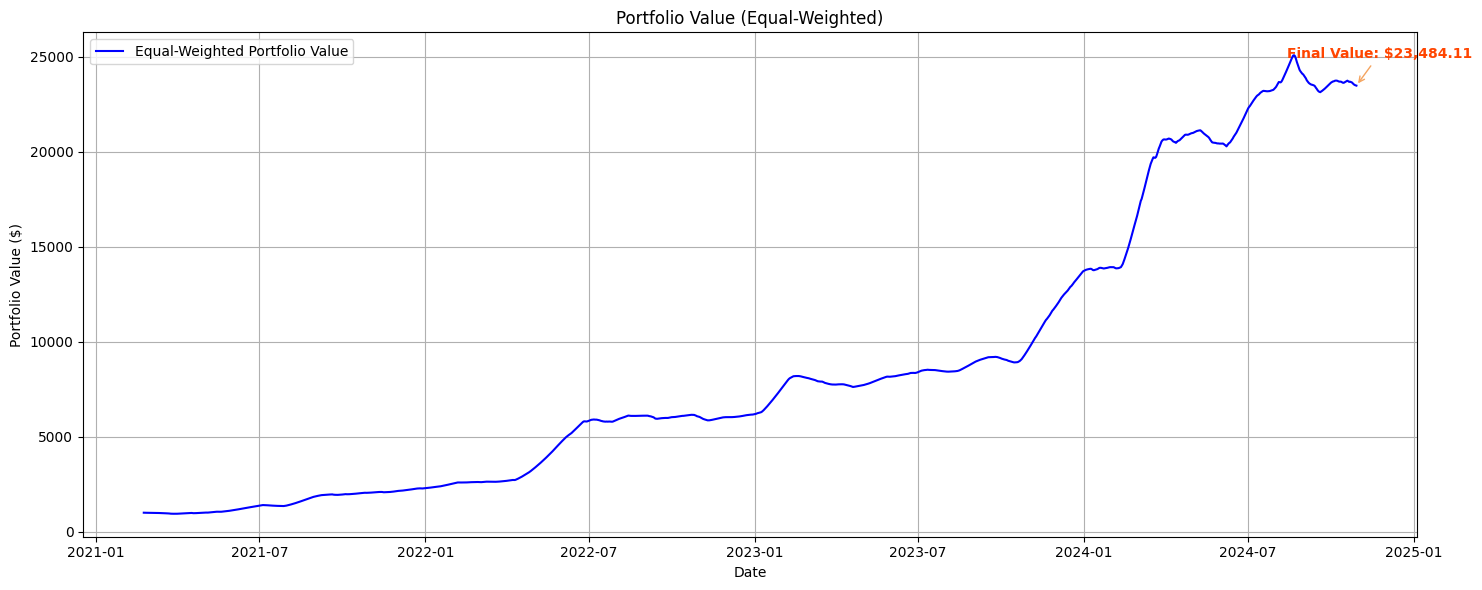

Equal Weights:
AAVE: 2.44%
ADA: 2.44%
APT: 2.44%
ARB: 2.44%
ATOM: 2.44%
AVAX: 2.44%
BCH: 2.44%
BNB: 2.44%
BTC: 2.44%
DOGE: 2.44%
DOT: 2.44%
ETC: 2.44%
ETH: 2.44%
FDUSD: 2.44%
FET: 2.44%
FIL: 2.44%
FTM: 2.44%
HBAR: 2.44%
ICP: 2.44%
IMX: 2.44%
INJ: 2.44%
KAS: 2.44%
LINK: 2.44%
LTC: 2.44%
NEAR: 2.44%
OP: 2.44%
PEPE: 2.44%
RENDER: 2.44%
RUNE: 2.44%
SHIB: 2.44%
SOL: 2.44%
STX: 2.44%
SUI: 2.44%
TAO: 2.44%
TRX: 2.44%
UNI: 2.44%
VET: 2.44%
WIF: 2.44%
XLM: 2.44%
XMR: 2.44%
XRP: 2.44%


In [9]:
from skfolio.optimization import EqualWeighted


equal_weighted_portfolio = EqualWeighted()
optimized_portfolio = equal_weighted_portfolio.fit(port_matrix)
weights = optimized_portfolio.weights_


initial_investment = 1000
portfolio_returns = port_matrix.dot(weights)
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

plt.figure(figsize=(15, 6))
plt.plot(portfolio_value.index, portfolio_value, label="Equal-Weighted Portfolio Value", color='blue')

final_value = portfolio_value.iloc[-1]
final_date = portfolio_value.index[-1]

plt.annotate(
    f"Final Value: ${final_value:,.2f}",
    xy=(final_date, final_value),
    xytext=(-50, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color='sandybrown'),
    fontsize=10,
    color="orangered",
    fontweight='bold'
)


plt.title("Portfolio Value (Equal-Weighted)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

print("Equal Weights:")
for asset, weight in zip(port_matrix.columns, weights):
    print(f"{asset}: {weight:.2%}")

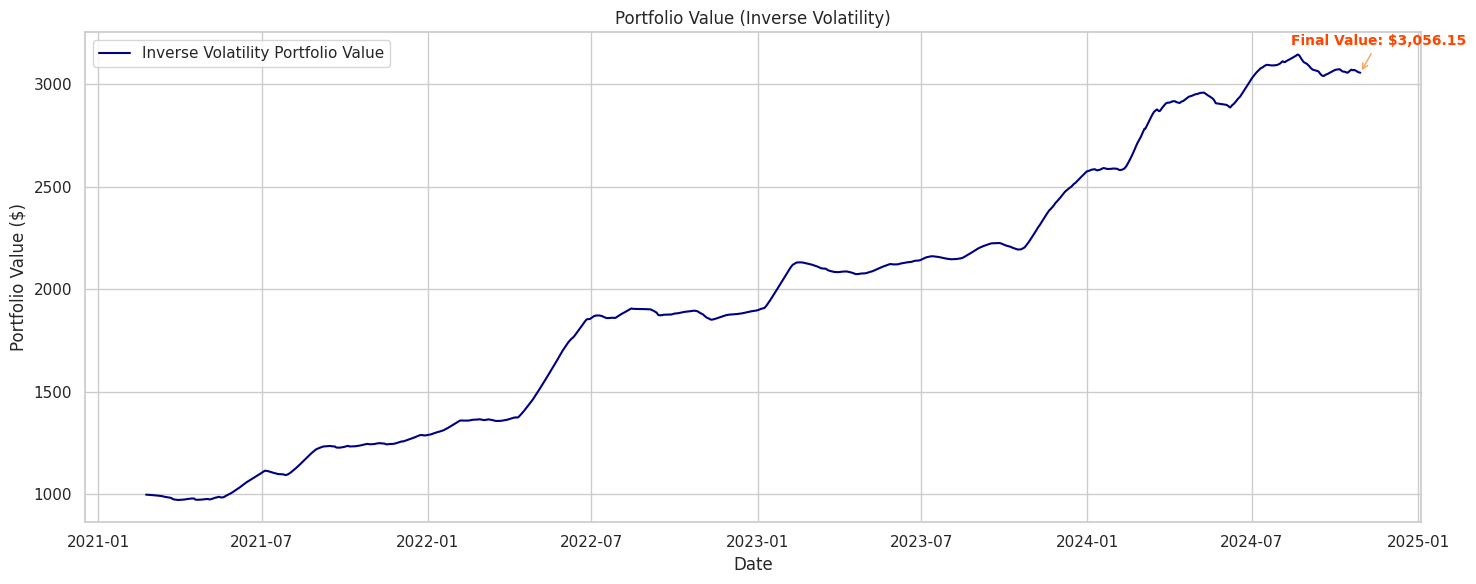

Inverse Volatility Weights:
AAVE: 1.10%
ADA: 1.03%
APT: 1.12%
ARB: 2.04%
ATOM: 0.99%
AVAX: 0.70%
BCH: 1.06%
BNB: 1.23%
BTC: 2.03%
DOGE: 0.44%
DOT: 1.20%
ETC: 1.19%
ETH: 1.37%
FDUSD: 43.82%
FET: 0.72%
FIL: 1.07%
FTM: 0.53%
HBAR: 1.10%
ICP: 1.12%
IMX: 1.01%
INJ: 0.76%
KAS: 1.80%
LINK: 1.06%
LTC: 1.50%
NEAR: 0.71%
OP: 1.01%
PEPE: 0.48%
RENDER: 9.51%
RUNE: 0.83%
SHIB: 0.64%
SOL: 0.61%
STX: 0.92%
SUI: 1.90%
TAO: 2.35%
TRX: 1.66%
UNI: 1.16%
VET: 1.22%
WIF: 2.60%
XLM: 1.65%
XMR: 1.49%
XRP: 1.29%


In [ ]:
from skfolio.optimization import InverseVolatility

inverse_volatility_portfolio = InverseVolatility()
optimized_portfolio = inverse_volatility_portfolio.fit(port_matrix)

weights = optimized_portfolio.weights_
initial_investment = 1000
portfolio_returns = port_matrix.dot(weights)
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

plt.figure(figsize=(15, 6))
plt.plot(portfolio_value.index, portfolio_value, label="Inverse Volatility Portfolio Value", color='navy')

final_value = portfolio_value.iloc[-1]
final_date = portfolio_value.index[-1]

plt.annotate(
    f"Final Value: ${final_value:,.2f}",
    xy=(final_date, final_value),
    xytext=(-50, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color='sandybrown'),
    fontsize=10,
    color="orangered",
    fontweight='bold'
)

plt.title("Portfolio Value (Inverse Volatility)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()



print("Inverse Volatility Weights:")
for asset, weight in zip(port_matrix.columns, weights):
    print(f"{asset}: {weight:.2%}")

-------

####  **🚩2. Mean Risk Optimization**


- To **Maximizing** the **Return** Over Specific Periods.


**🎯  Challenges**:

*The Following Parameters Must be Adjusted in a Optimized Way While Now We Put the Constraints Manually that can be caused of High Sensitivity of The Results By Changin the Pramaters*:

  1.  **Minimum Weights**
  2.  **Maximum Weights**
  
  ------

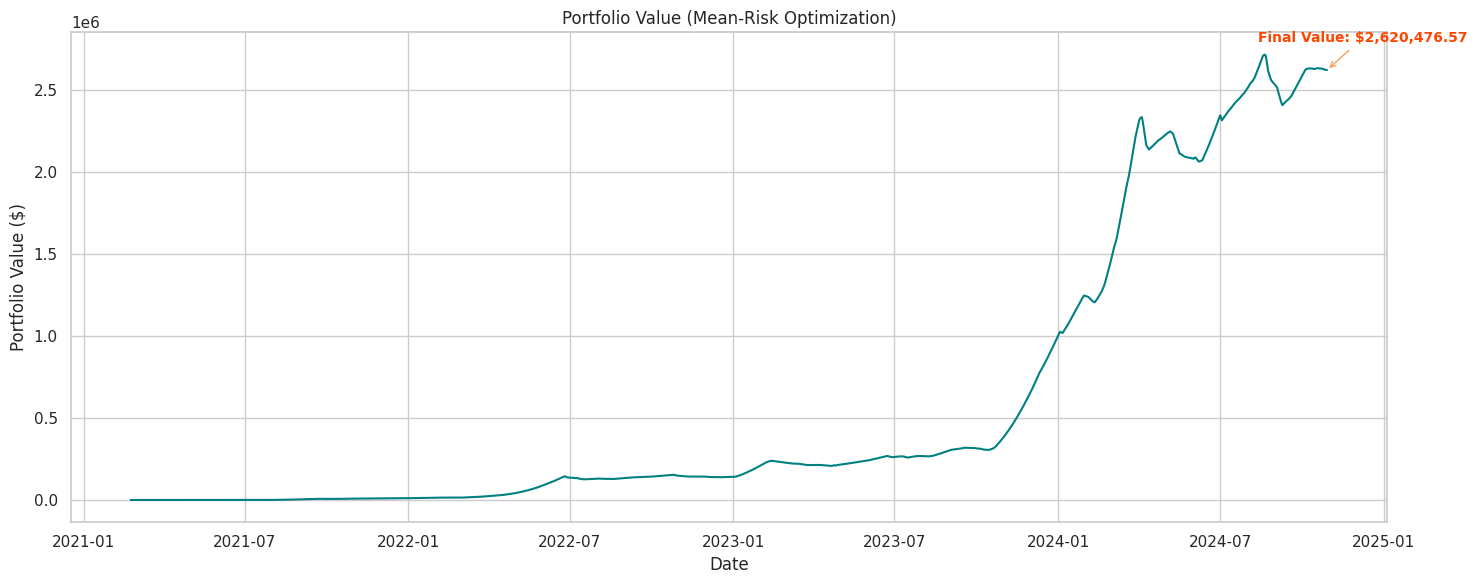

--------------------------------------------------
Optimized Weights (Mean-Risk):

AAVE: 1.00%
ADA: 1.00%
APT: 1.00%
ARB: 1.00%
ATOM: 1.00%
AVAX: 1.00%
BCH: 1.00%
BNB: 1.00%
BTC: 1.00%
DOGE: 1.00%
DOT: 1.00%
ETC: 1.00%
ETH: 1.00%
FDUSD: 1.00%
FET: 1.00%
FIL: 1.00%
FTM: 25.00%
HBAR: 1.00%
ICP: 1.00%
IMX: 1.00%
INJ: 1.00%
KAS: 1.00%
LINK: 1.00%
LTC: 1.00%
NEAR: 1.00%
OP: 1.00%
PEPE: 1.00%
RENDER: 1.00%
RUNE: 12.00%
SHIB: 1.00%
SOL: 25.00%
STX: 1.00%
SUI: 1.00%
TAO: 1.00%
TRX: 1.00%
UNI: 1.00%
VET: 1.00%
WIF: 1.00%
XLM: 1.00%
XMR: 1.00%
XRP: 1.00%


In [ ]:
from skfolio.optimization import MeanRisk
from skfolio.optimization import ObjectiveFunction
from skfolio.measures import RiskMeasure

num_assets = len(port_matrix.columns)

mean_risk_portfolio = MeanRisk(
    objective_function=ObjectiveFunction.MAXIMIZE_RETURN,
    risk_measure=RiskMeasure.VARIANCE,
    risk_aversion=1.0,
    min_weights=0.01,
    max_weights=0.25,
    budget=1.0
)

optimized_portfolio = mean_risk_portfolio.fit(port_matrix)
weights = optimized_portfolio.weights_


def calculate_portfolio_value(port_matrix, weights, initial_investment):
    portfolio_returns = port_matrix.dot(weights)
    portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()
    return portfolio_value

initial_investment = 1000
portfolio_value = calculate_portfolio_value(port_matrix, weights, initial_investment)


plt.figure(figsize=(15, 6))
plt.plot(portfolio_value.index, portfolio_value, label="Mean-Risk Portfolio Value", color='teal')


final_value = portfolio_value.iloc[-1]
final_date = portfolio_value.index[-1]

plt.annotate(
    f"Final Value: ${final_value:,.2f}",
    xy=(final_date, final_value),
    xytext=(-50, 20),  # Offset for annotation
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color='sandybrown'),
    fontsize=10,
    color="orangered",
    fontweight='bold'
)


plt.title("Portfolio Value (Mean-Risk Optimization)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("-"*50)
print("Optimized Weights (Mean-Risk):\n")
for asset, weight in zip(port_matrix.columns, weights):
    print(f"{asset}: {weight:.2%}")